In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

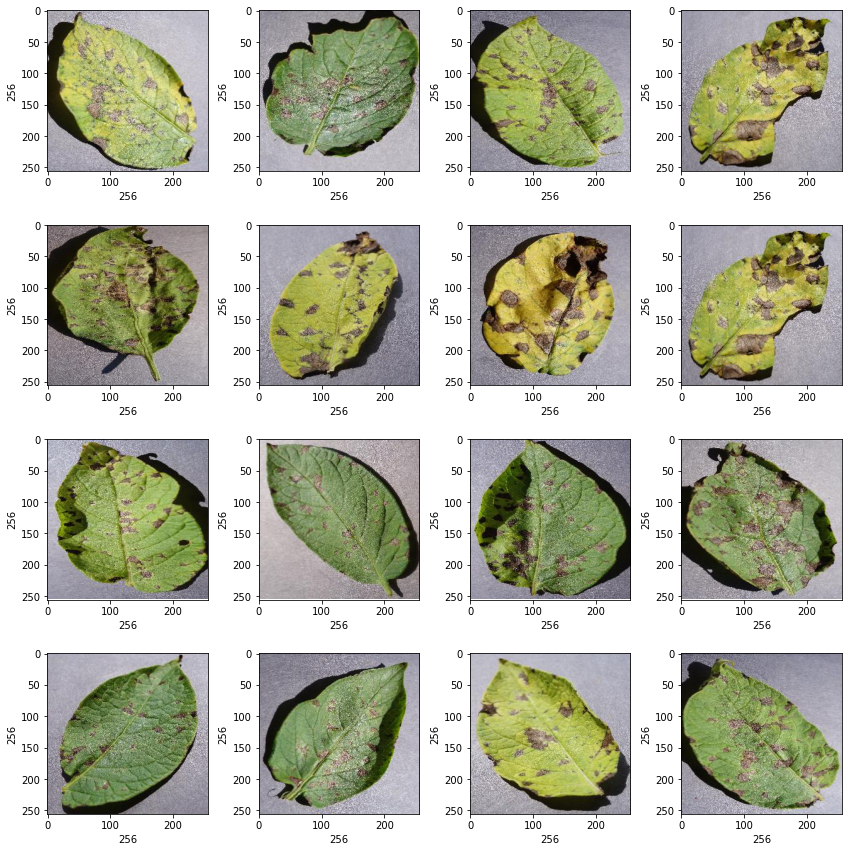

In [10]:
plt.figure(figsize=(12,12))
path = "../input/leaf-image-dataset/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [11]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
dir = "../input/leaf-image-dataset/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1


for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])
    


In [13]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()


0    300
1    300
2    300
dtype: int64

In [14]:
image_list[0].shape

(256, 256, 3)

In [15]:
label_list = np.array(label_list)
label_list.shape

(900,)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [17]:
#Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 225800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [22]:
epochs = 15
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val))

Epoch 1/15
5/5 [==============================] - 8s 1s/step - loss: 1.0617 - accuracy: 0.3438 - val_loss: 1.0109 - val_accuracy: 0.4583
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 1.0081 - accuracy: 0.5608 - val_loss: 0.9639 - val_accuracy: 0.5833
Epoch 3/15
5/5 [==============================] - 7s 1s/step - loss: 0.9536 - accuracy: 0.5625 - val_loss: 0.9132 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 0.9040 - accuracy: 0.5451 - val_loss: 0.8533 - val_accuracy: 0.6319
Epoch 5/15
5/5 [==============================] - 6s 1s/step - loss: 0.8565 - accuracy: 0.6319 - val_loss: 0.8051 - val_accuracy: 0.6944
Epoch 6/15
5/5 [==============================] - 5s 1s/step - loss: 0.8163 - accuracy: 0.6476 - val_loss: 0.7616 - val_accuracy: 0.6944
Epoch 7/15
5/5 [==============================] - 5s 1s/step - loss: 0.7818 - accuracy: 0.6458 - val_loss: 0.7304 - val_accuracy: 0.6944
Epoch 8/15
5/5 [=========================

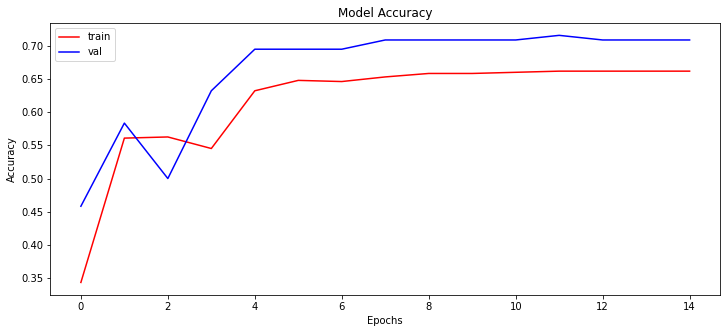

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [24]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 0s 68ms/step - loss: 0.5751 - accuracy: 0.6389
Test Accuracy: 63.88888955116272


In [25]:
y_pred = model.predict(x_test)

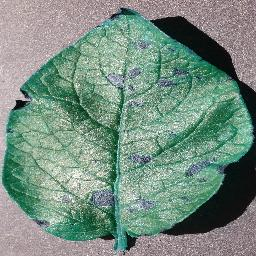

In [26]:
img = array_to_img(x_test[10])
img

In [27]:
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Potato-Early_blight
Predicted :  Potato-Early_blight
